In [9]:
# import all necessary libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from math import log
import networkx as nx
from igraph import Graph, plot
import igraph as ig
from math import log
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import torch
import torch
import torch.nn.functional as F
from torch_geometric.nn import GAE, GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import from_networkx


In [2]:
%pip install torch torch-geometric torch-scatter torch-sparse

Note: you may need to restart the kernel to use updated packages.


Instead of using handcrafted features (like degree, clustering coefficient, etc.), we use Graph Autoencoders to learn node embeddings directly from the graph structure + features.

In [3]:
file_path = 'featured_dataset.csv'
df = pd.read_csv(file_path)


In [4]:
df.shape

(3532, 17)

In [5]:
df.head(10)

,Node,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,EigenvectorCentrality,Eccentricity,Constraint,MeanNeighborDegree,LocalClusterSizes,LocalClusterDensities,sorensen_indices,participation_coefficient,CommunitySize,CommunityDensity,CommunityAssortativity
0,1,0.700547,0.419118,-0.057036,0.261376,1.000118,0.000006,1.043499,1.048030,-1.206914,-1.187895,0.047468,0.128317,1.078821,-0.849481,0.042446,-0.133841
1,2,0.597675,0.888889,-0.057268,0.261258,1.000100,0.000002,1.043499,1.100383,-1.206914,-1.187895,0.047468,0.122203,1.073933,-0.849481,0.042446,-0.133841
2,3,0.700547,0.632353,-0.057130,0.261376,1.000113,0.000007,1.043499,1.048897,-1.206914,-1.187895,0.047468,0.143140,1.078447,-0.849481,0.042446,-0.133841
3,4,0.597675,0.866667,-0.057259,0.261258,1.000116,0.000002,1.043499,1.149038,-1.206914,-1.187895,0.047468,0.110459,1.074068,-0.849481,0.042446,-0.133841
4,5,0.643779,0.333333,-0.057085,0.261308,1.000101,0.000012,1.043499,1.056431,-1.206914,-1.187895,0.047468,0.119667,1.076862,-0.849481,0.042446,-0.133841
5,6,0.530000,0.933333,-0.057273,0.261190,1.000088,0.000002,1.043499,1.189174,-1.206914,-1.187895,0.047468,0.126051,1.059941,-0.849481,0.042446,-0.133841
6,7,0.740272,0.431579,-0.042650,0.274769,1.000132,0.000269,1.043499,1.050490,-0.829093,-0.830723,0.054209,0.090114,1.079451,-0.849481,0.042446,-0.133841
7,8,0.564852,0.678571,-0.057251,0.261224,1.000115,0.000002,1.043499,1.170652,-1.206914,-1.187895,0.047468,0.113541,1.069639,-0.849481,0.042446,-0.133841
8,9,1.119786,0.397243,-0.055862,0.262055,1.000302,0.000023,1.043499,1.023864,-1.206914,-1.187895,0.047468,0.156285,1.081540,-0.849481,0.042446,-0.133841
9,10,0.597675,0.822222,-0.057270,0.261258,1.000068,0.000008,1.043499,1.062901,-1.206914,-1.187895,0.047468,0.148043,1.072578,-0.849481,0.042446,-0.133841


In [ ]:
# df_dropped is your feature dataframe
df_features = df.sort_values(by='Node')
x = torch.tensor(df_features.drop(columns=['Node']).values, dtype=torch.float)
# Extract node features and ensure order by node index and edges
G = nx.read_edgelist("facebook_combined.txt", nodetype=int)

In [16]:
# Make sure all nodes in df['Node'] exist in G
node_ids = df['Node'].tolist()
G = G.subgraph(node_ids).copy()

In [17]:
# Convert NetworkX graph to PyG Data format
pyg_graph = from_networkx(nx.Graph(G))

In [18]:
pyg_graph.x = x

In [19]:
# Define Graph Autoencoder model
from torch_geometric.nn import GCNConv

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)

In [20]:
# Train the GAE model
from torch_geometric.nn import GAE

# Initialize model
out_channels = 32  # embedding size
model = GAE(Encoder(pyg_graph.num_node_features, out_channels))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    z = model.encode(pyg_graph.x, pyg_graph.edge_index)
    loss = model.recon_loss(z, pyg_graph.edge_index)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.9044
Epoch 20, Loss: 1.0774
Epoch 40, Loss: 0.9655
Epoch 60, Loss: 0.9352
Epoch 80, Loss: 0.9114
Epoch 100, Loss: 0.8975
Epoch 120, Loss: 0.8841
Epoch 140, Loss: 0.8819
Epoch 160, Loss: 0.8746
Epoch 180, Loss: 0.8724


In [21]:
print(pyg_graph.x.shape[0])            # Number of rows in feature matrix
print(pyg_graph.edge_index.max())      # Highest node index in edge list

3532
tensor(3531)


In [22]:
# Get Embeddings and Use for Clustering
model.eval()
with torch.no_grad():
    z = model.encode(pyg_graph.x, pyg_graph.edge_index)  # shape: [num_nodes, out_channels]

# Convert to NumPy
embeddings = z.cpu().numpy()

# Cluster embeddings using KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(embeddings)

print(f'Silhouette Score on GAE Embeddings: {silhouette_score(embeddings, labels):.4f}')

Silhouette Score on GAE Embeddings: 0.5753


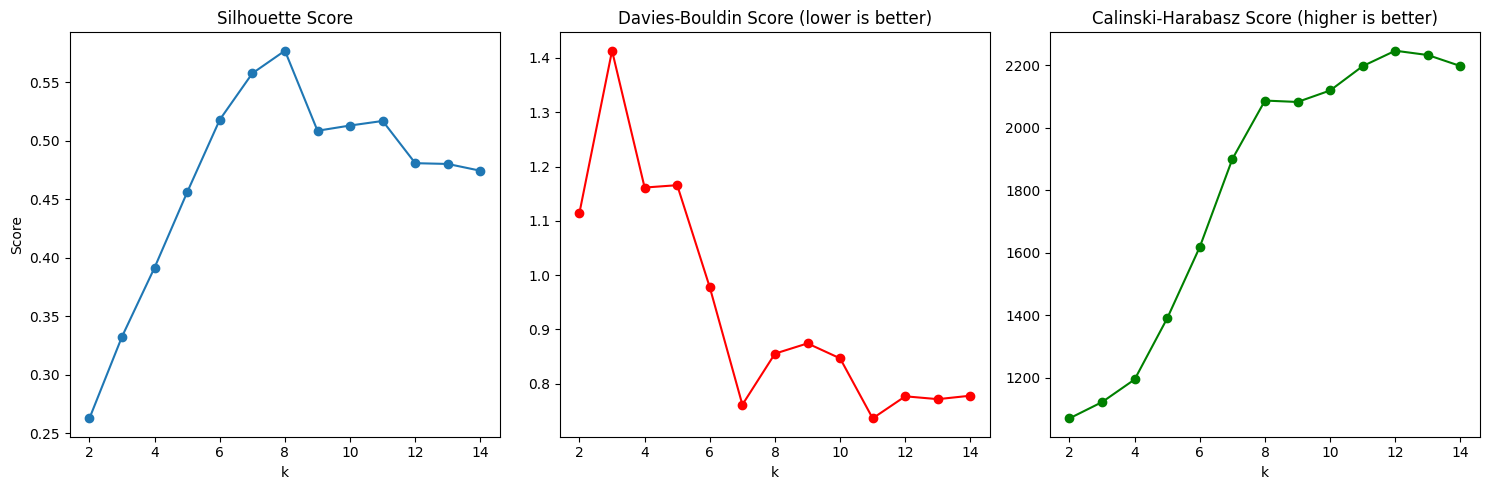

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Range of clusters to test
k_values = list(range(2, 15))

sil_scores = []
db_scores = []
ch_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)

    sil_scores.append(silhouette_score(embeddings, labels))
    db_scores.append(davies_bouldin_score(embeddings, labels))
    ch_scores.append(calinski_harabasz_score(embeddings, labels))

# Plot the scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_values, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")

plt.subplot(1, 3, 2)
plt.plot(k_values, db_scores, marker='o', color='r')
plt.title("Davies-Bouldin Score (lower is better)")
plt.xlabel("k")

plt.subplot(1, 3, 3)
plt.plot(k_values, ch_scores, marker='o', color='g')
plt.title("Calinski-Harabasz Score (higher is better)")
plt.xlabel("k")

plt.tight_layout()
plt.show()

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import pandas as pd

# Normalize the embeddings first (DBSCAN is distance-based)
scaled_embeddings = StandardScaler().fit_transform(embeddings)

# Define grid
eps_values = [0.3, 0.5, 0.7, 0.9, 1.2]
min_samples_values = [3, 5, 10]

# Store results
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_embeddings)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:
            sil_score = silhouette_score(scaled_embeddings, labels)
            db_score = davies_bouldin_score(scaled_embeddings, labels)
            ch_score = calinski_harabasz_score(scaled_embeddings, labels)
        else:
            sil_score = db_score = ch_score = -1  # invalid

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score,
            'davies_bouldin': db_score,
            'calinski_harabasz': ch_score
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='silhouette', ascending=False)

# Display top 10 DBSCAN configurations
print("Top 10 DBSCAN configurations by silhouette score:")
print(results_df.head(10).to_string(index=False))

# Best config (optional print)
best_config = results_df.iloc[0]
print(f"Best DBSCAN Config -> eps={best_config['eps']}, min_samples={best_config['min_samples']}, silhouette={best_config['silhouette']:.4f}")

Top 10 DBSCAN configurations by silhouette score:
 eps  min_samples  n_clusters  n_noise  silhouette  davies_bouldin  calinski_harabasz
 0.9           10          14      502    0.378695        1.268456         677.222595
 0.9            5          24      291    0.285343        1.333832         512.609131
 1.2           10           9      251    0.224069        1.590199         430.028168
 0.7            5          31      547    0.132214        1.300633         314.278534
 0.7           10          25      882    0.105208        1.159996         290.444702
 0.9            3          33      206    0.051431        1.241268         226.771545
 0.7            3          57      368    0.032889        1.285290         219.713501
 0.5           10          17     1627    0.008821        1.141414         211.150635
 1.2            5          14      156   -0.110264        1.577380         127.155769
 0.5            5          45     1093   -0.145938        1.250698         135.075226
Best

In [29]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Normalize GAE embeddings
scaled_embeddings = StandardScaler().fit_transform(embeddings)

# Run HAC
n_clusters = 8  # or tune this
hac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = hac.fit_predict(scaled_embeddings)

# Evaluate
sil = silhouette_score(scaled_embeddings, labels)
db = davies_bouldin_score(scaled_embeddings, labels)
ch = calinski_harabasz_score(scaled_embeddings, labels)

print(f"HAC (k={n_clusters}) → Silhouette: {sil:.4f}, Davies-Bouldin: {db:.4f}, Calinski-Harabasz: {ch:.4f}")

HAC (k=8) → Silhouette: 0.5239, Davies-Bouldin: 0.7135, Calinski-Harabasz: 1749.0197


In [30]:
# Reconstruct edges (predict new links)
with torch.no_grad():
    z = model.encode(pyg_graph.x, pyg_graph.edge_index)
    adj_pred = torch.sigmoid(torch.matmul(z, z.t()))

# adj_pred[i][j] gives the likelihood of an edge between node i and j

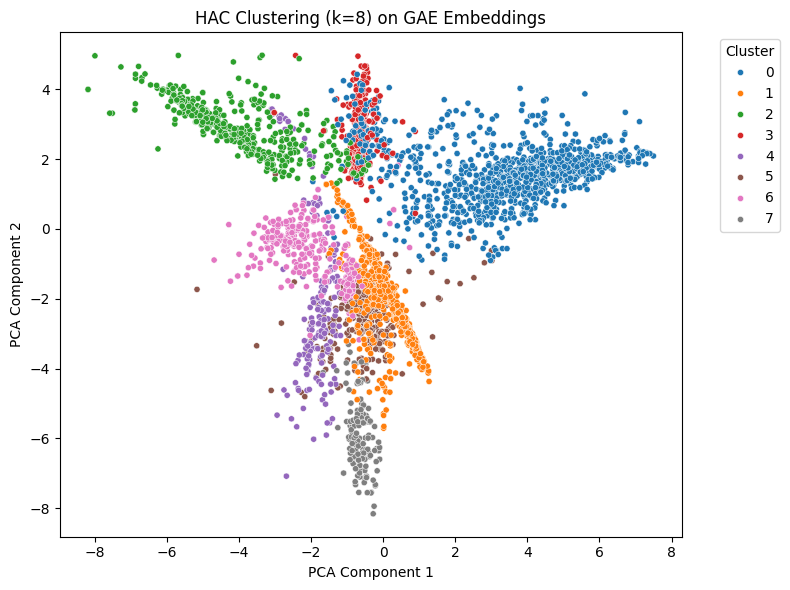

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='tab10', s=20)
plt.title(f"HAC Clustering (k={n_clusters}) on GAE Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Current Setup:

dataset includes:
*	Node IDs
*	Edges (connections between users)
*	Features derived from graph structure: centrality, clustering coefficient, PageRank, etc.
*	Learned GAE embeddings: abstract structural representation from the graph


Missing behavioral and content-based signals, which are critical for high-performance recommendation engines.
Example

Likes, shares, comments - This helps in Signals user interests and engagement

Clickstream, views - Tells what users browse vs. ignore

Watch history  - Sequential behavior is key for personalization

Timestamps - Helps with recency and trend detection

Missing Content Metadata (Items/Groups/Posts)

* Post topics or tags
* Group descriptions
* Text, image, or video embeddings

GAE is powerful for structural representation — it encodes who is connected to whom and how, but:
*	It doesn’t see what users are doing
*	It doesn’t know what they prefer
*	It doesn’t understand content similarity without side features

So it’s very useful for:
*	Link prediction
*	Graph-based clustering
*	Cold-start friend recommendation

But limited for:
*	Fine-grained content or item recommendations
*	Personalization without behavioral 

Since data only has nodes and edges, this is a great graph-based community detection project, and you can position GAE as:

A proof-of-concept that structural embeddings alone can identify latent clusters, but integrating behavioral data would improve recommendation quality.
While GAE enables community-aware clustering from structural data, a full-scale recommendation engine needs behavioral, profile, and content-level integration for meaningful personalization and scalability.

